<details>
<summary><strong>Indice</strong></summary>

- [Data Exploration](#data-exploration)
- [Assunzioni e definizioni](#assunzioni-e-definizioni)
- [Valori mancanti](#valori-mancanti)
- [Bilanciamento del target](#bilanciamento-del-target)
- [Variabili numeriche](#variabili-numeriche)
- [Variabili categoriche](#variabili-categoriche)
- [Correlazioni (numeriche + target)](#correlazioni)
- [Conclusioni](#conclusioni)
- [Evitiamo il leakage](#evitiamo-il-leakage)

</details>


<a id="data-exploration"></a>
# Data Exploration

In questo notebook eseguiamo analiziamo il dataset **UCI Heart Disease – subset Cleveland** per poi addestrare il modelli. Nella fase di analisi cerceremo di comprendere, da un punto di vista operativo: quali variabili abbiamo, come sono distribuite, dove mancano dati, quanto sono sbilanciate le classi e quali segnali preliminari suggeriscono possibili trasformazioni o feature utili.

L’obiettivo finale è duplice: (1) validare le scelte di preprocessing che useremo nella pipeline (imputazione, encoding, scaling), e (2) raccogliere evidenze per motivare le decisioni in tesina (metrica principale, feature engineering, selezione del modello).

**Obbiettivi**
L’obiettivo finale è duplice:
1. Validare le scelte di preprocessing che useremo nella pipeline (imputazione, encoding, scaling);
2. Raccogliere i risultati ottenuti e mediante le metrica principale selezionare il modello più efficace.

In [228]:
import sys
from pathlib import Path
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    sys.path.append(str(ROOT.parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.models.read import load_cleveland, TARGET_BIN, CATEGORICAL, NUMERIC

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

<a id="assunzioni-e-definizioni"></a>
## Assunzioni e definizioni

- **Target**: partiamo da `num ∈ {0,1,2,3,4}` e lo binarizziamo in `target = 1{num>0}`: 1 = presenza, 0 = assenza.
- **Variabili numeriche**: `age, trestbps, chol, thalach, oldpeak`.
- **Variabili categoriche**: `sex, cp, fbs, restecg, exang, slope, ca, thal`.
- **Metrica principale**: **F1**, perché le classi non sono perfettamente bilanciate e vogliamo pesare insieme precision e recall.
- **Preprocessing in pipeline**: imputazione (median/most_frequent), scaling delle numeriche, One-Hot per le categoriche → tutto **dentro** la Pipeline per evitare leakage.
- **Feature Engineering**: eventuali nuove feature (rapporti/interazioni) saranno create **dentro** la pipeline, mai “a mano” su tutto il dataset.


In [229]:
df = load_cleveland()  # legge da data/raw/ o scarica da UCI
print("Shape:", df.shape)
df.head()

Shape: (303, 15)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


<a id="valori-mancanti"></a>
### Cosa guardare nei “missing”

I valori mancanti ci forniscono informazioni sulla qualità e la copertura delle variabili. Qui verifichiamo:
- **Dove** mancano dati e **quanto** (conteggio e %). Nel dataset Cleveland, notiamo come i campi:
    1. `ca`, valore fortemente collegato alla malattia;
    2. `thal`, sato della talassemia (normal/fixed/reversible);
    possono avere dei buchi.
- Se la quota di missing è **moderata**, l’imputazione “semplice” è spesso sufficiente (median per numeriche, most_frequent per categoriche).
- Se una categoria è quasi assente, l’One-Hot produrrà colonne quasi vuote: non è un dramma su dataset piccoli, ma va tenuto a mente.


In [230]:
display(df.dtypes.to_frame("dtype"))
display(df.describe(include="all").transpose())

,dtype
age,float64
sex,category
cp,category
trestbps,float64
chol,float64
fbs,category
restecg,category
thalach,float64
exang,category
oldpeak,float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,303.0,NaN,NaN,NaN,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,2.0,1.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cp,303.0,4.0,4.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,303.0,NaN,NaN,NaN,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,NaN,NaN,NaN,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,2.0,0.0,258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restecg,303.0,3.0,0.0,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thalach,303.0,NaN,NaN,NaN,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,2.0,0.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldpeak,303.0,NaN,NaN,NaN,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [231]:
na_count = df.isna().sum().sort_values(ascending=False)
na_pct = (na_count / len(df)).round(3)
missing = pd.DataFrame({"n_missing": na_count, "pct": na_pct})
missing[missing["n_missing"] > 0]


,n_missing,pct
ca,4,0.013
thal,2,0.007


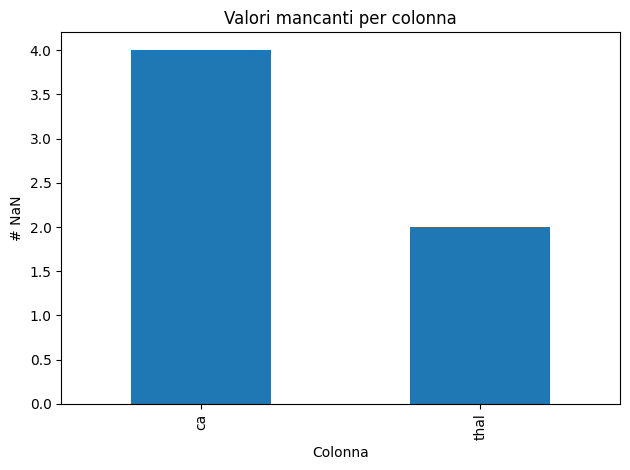

In [232]:
miss = df.isna().sum().sort_values(ascending=False)
miss = miss[miss>0]
if not miss.empty:
    miss.plot(kind="bar")
    plt.title("Valori mancanti per colonna")
    plt.ylabel("# NaN"); plt.xlabel("Colonna")
    plt.tight_layout(); 
    plt.show()


<a id="bilanciamento-del-target"></a>
## Bilanciamento del target

La proporzione tra classe positiva e negativa guida due scelte:
1. **Metriсa di riferimento**: con classi non perfettamente bilanciate, **F1** è più informativa della sola Accuracy.
2. **Modellazione**: se la prevalenza fosse molto bassa/alta, potremmo considerare tecniche di ribilanciamento o class_weight; qui, in genere, non serve.

Guardiamo sia i **conteggi** sia le **percentuali** per fissare le idee.

,count,ratio
target,,
negativo,164,0.541
positivo,139,0.459


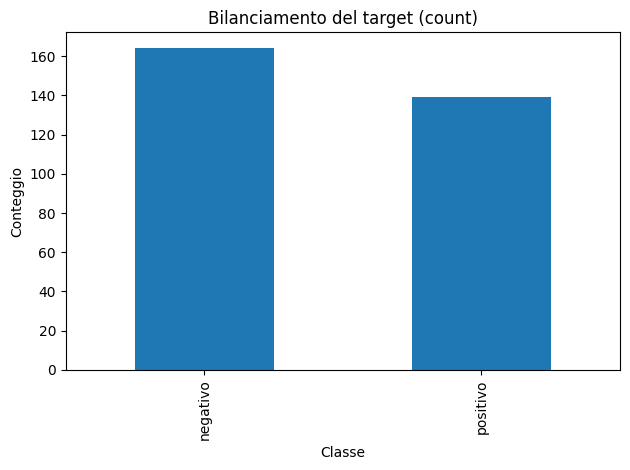

In [233]:
balance = df[TARGET_BIN].value_counts().rename(index={0:"negativo",1:"positivo"})
balance_pct = (balance / balance.sum()).round(3)
display(pd.DataFrame({"count": balance, "ratio": balance_pct}))

plt.figure()
(balance.sort_index()).plot(kind="bar")
plt.title("Bilanciamento del target (count)")
plt.xlabel("Classe"); plt.ylabel("Conteggio")
plt.tight_layout(); plt.show()


<a id="variabili-numeriche"></a>
## Variabili numeriche

Dobbiamo rispondere a tre quesiti prtatici:
- La **forma** è ragionevole? Ci sono code molto lunghe o outlier evidenti?
- Le **scale** sono diverse tra variabili? (Se sì, bisogna confermare che lo scaling è sensato.)
- Guardando la **sovrapposizione per classe** (positivi vs negativi), si vede un minimo di **separazione**? 
  Esempio tipico: `oldpeak` tende a essere più alto nei positivi; `thalach` (frequenza max) tende a essere più basso.

Queste osservazioni non “decidono il modello”, ma ci guidano nel'interpretazione dei risultati.

Di seguito gli istogrammi che mostrano l'andamento.

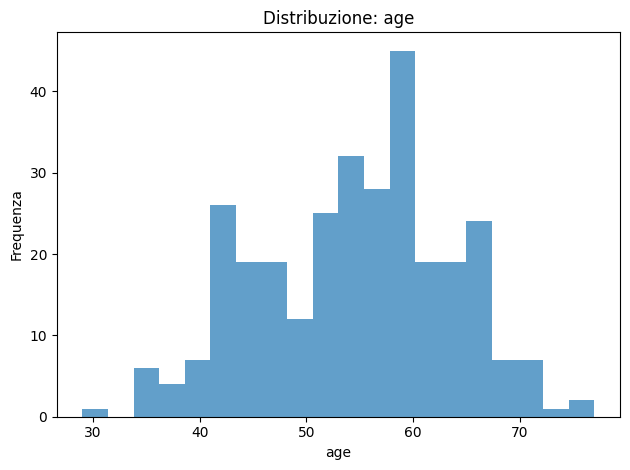

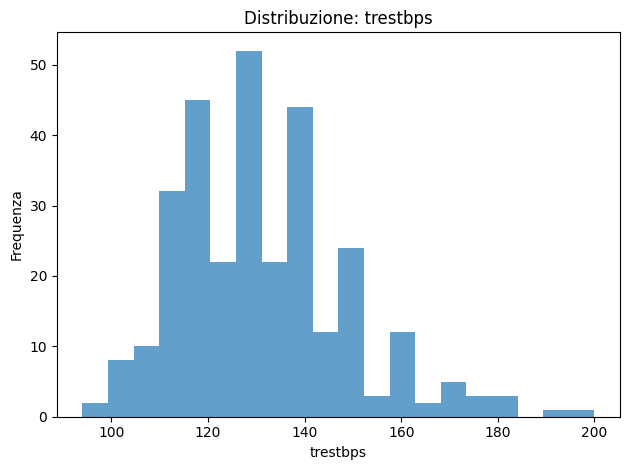

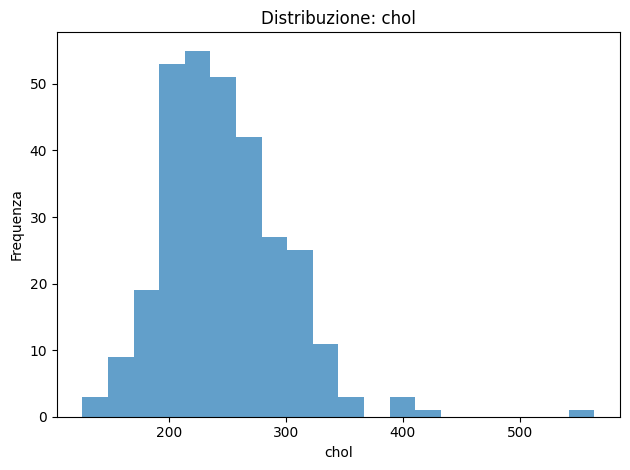

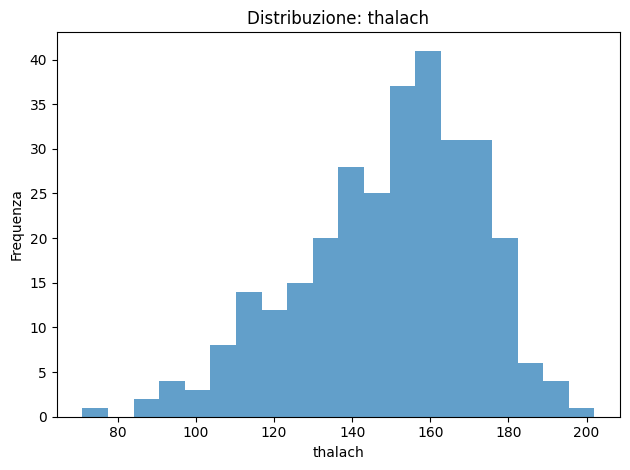

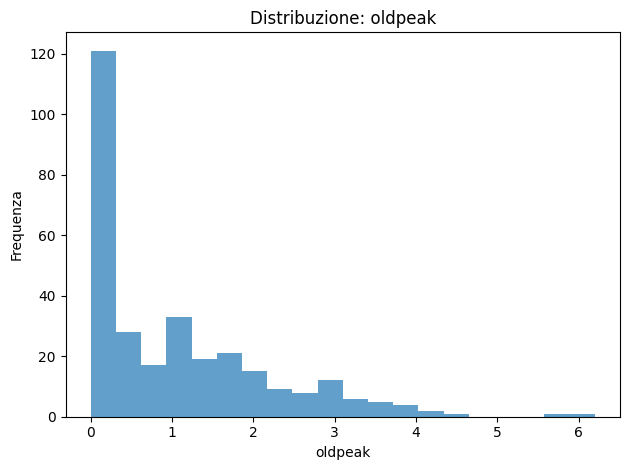

In [234]:
for col in NUMERIC:
    plt.figure()
    plt.hist(df[col].dropna(), bins=20, alpha=0.7)
    plt.title(f"Distribuzione: {col}")
    plt.xlabel(col); plt.ylabel("Frequenza")
    plt.tight_layout(); plt.show()


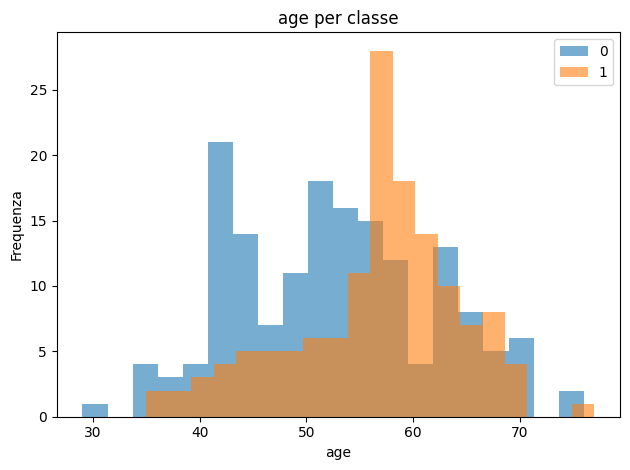

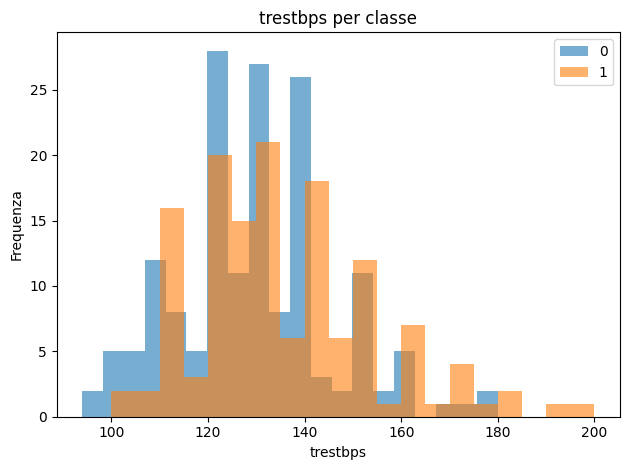

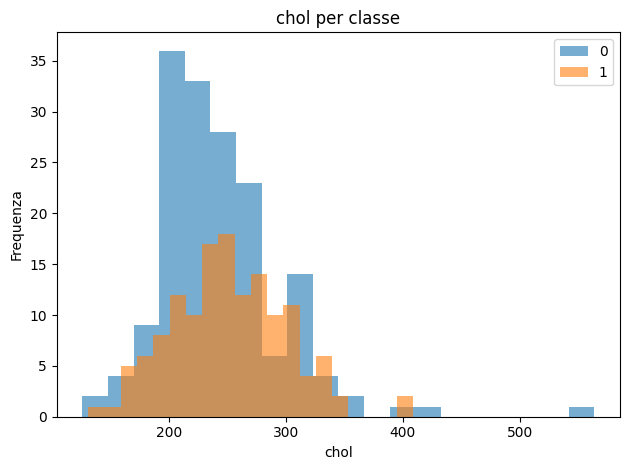

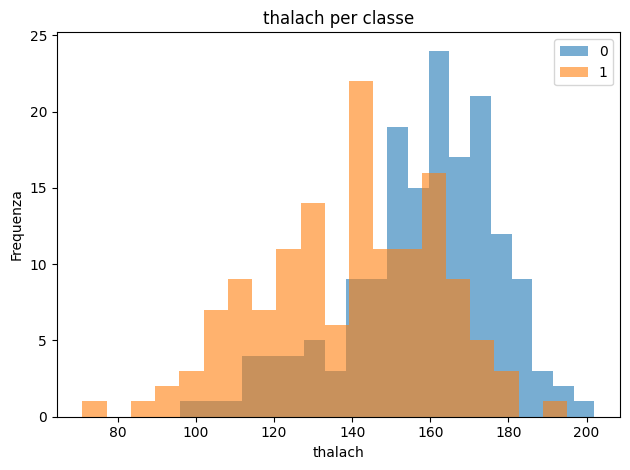

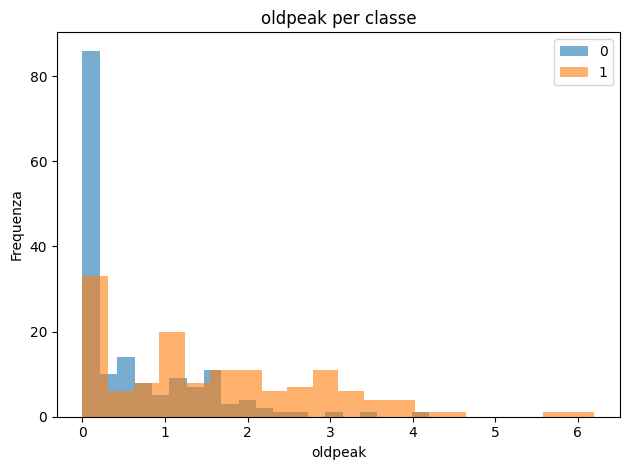

In [235]:
for col in NUMERIC:
    plt.figure()
    plt.hist(df[df[TARGET_BIN]==0][col].dropna(), bins=20, alpha=0.6, label="0")
    plt.hist(df[df[TARGET_BIN]==1][col].dropna(), bins=20, alpha=0.6, label="1")
    plt.title(f"{col} per classe")
    plt.xlabel(col); plt.ylabel("Frequenza")
    plt.legend()
    plt.tight_layout(); plt.show()


<a id="variabili-categoriche"></a>
## Variabili categoriche

Per ogni variabile categorica ci concentriamo su:
1. **Quante occorrenze** ha ogni categoria (per evitare categorie “fantasma”).
2. La **% di positivi** per categoria: se una categoria ha una percentuale molto più alta (o bassa) di positivi, quella variabile porta segnale.

Questa analisi è utile anche per ipotizzare **interazioni** semplici, portando a prendere in considerazione una fase di Feature Engineering (es. combinare `oldpeak` con `exang`).

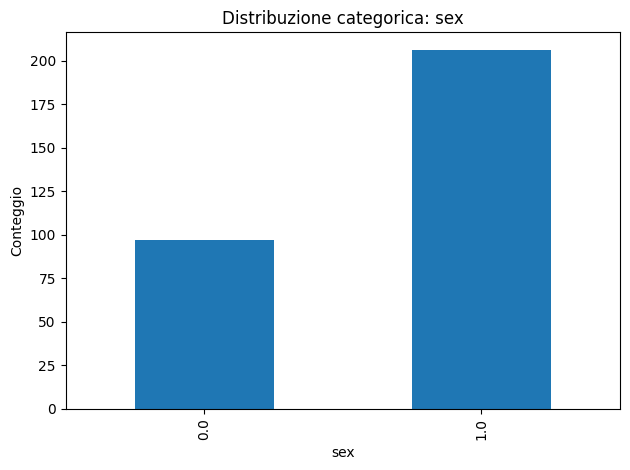

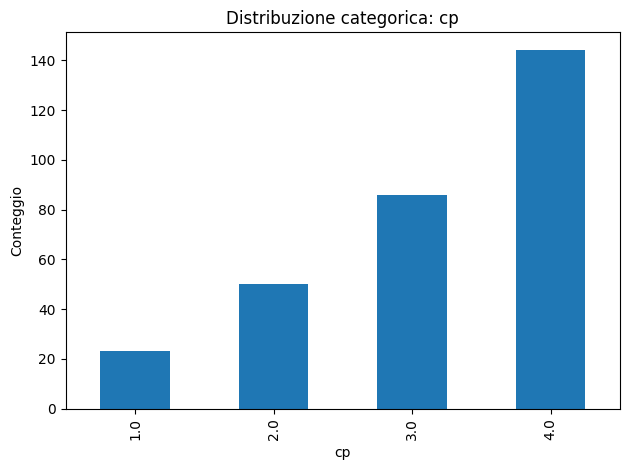

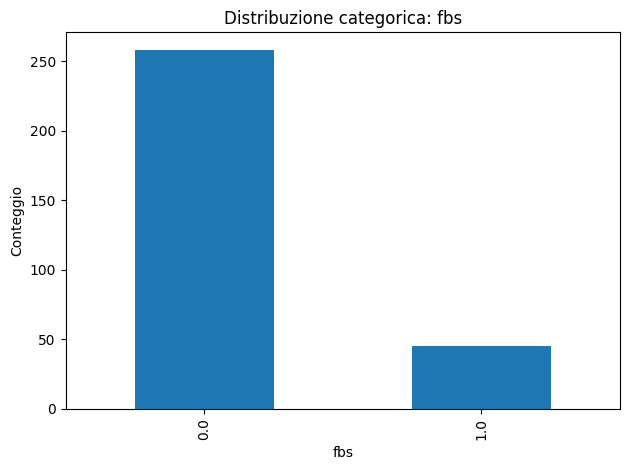

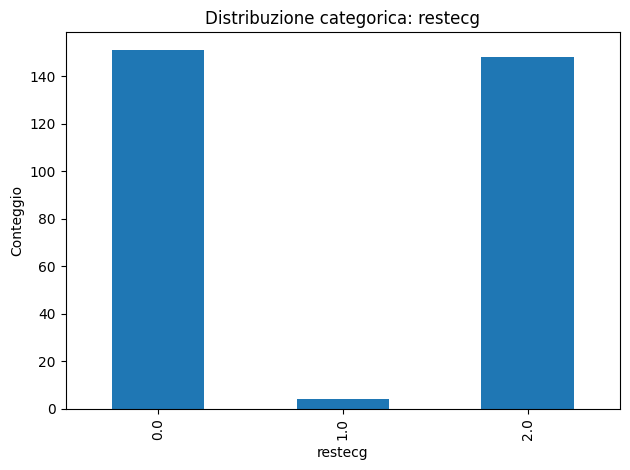

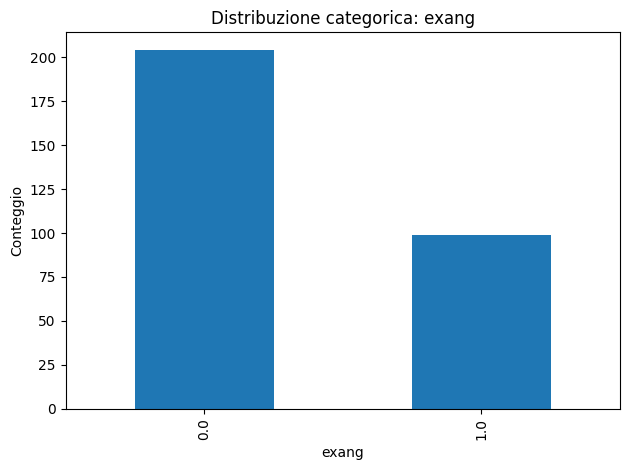

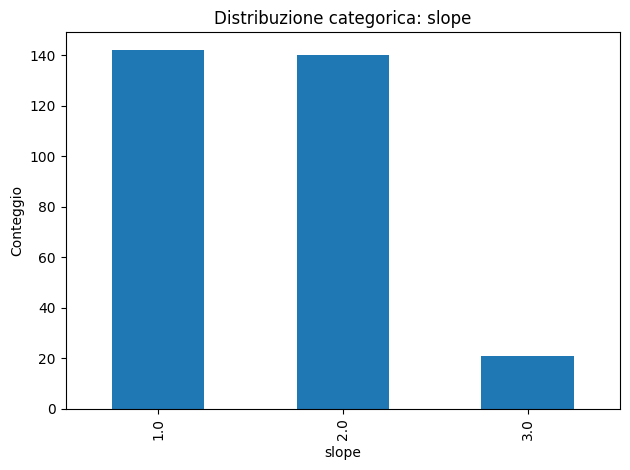

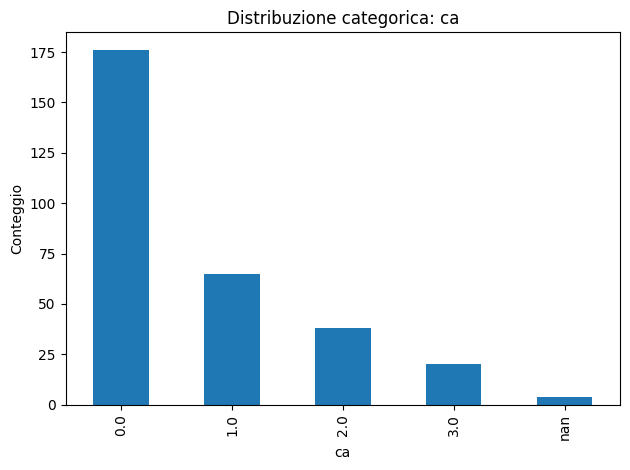

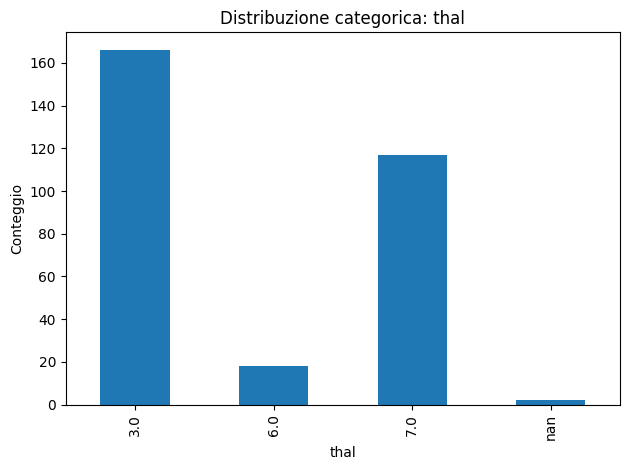

In [236]:
for col in CATEGORICAL:
    plt.figure()
    (df[col].value_counts(dropna=False).sort_index()).plot(kind="bar")
    plt.title(f"Distribuzione categorica: {col}")
    plt.xlabel(col); plt.ylabel("Conteggio")
    plt.tight_layout(); plt.show()


<a id="correlazioni"></a>
## Correlazioni (numeriche + target)

La correlazione di Pearson ci dà un’indicazione “lineare” del legame tra le variabili numeriche e il target. È utile per orientarsi, ma ha limiti:
- ignora le **categoriche** (che stiamo già guardando con la % per classe),
- misura solo relazioni **lineari**,
- non sostituisce la valutazione in **cross-validation**.

In breve: la heatmap è un **indizio visivo**, non il criterio con cui scegliamo il modello.


target,0,1
sex,,
0.0,0.742,0.258
1.0,0.447,0.553


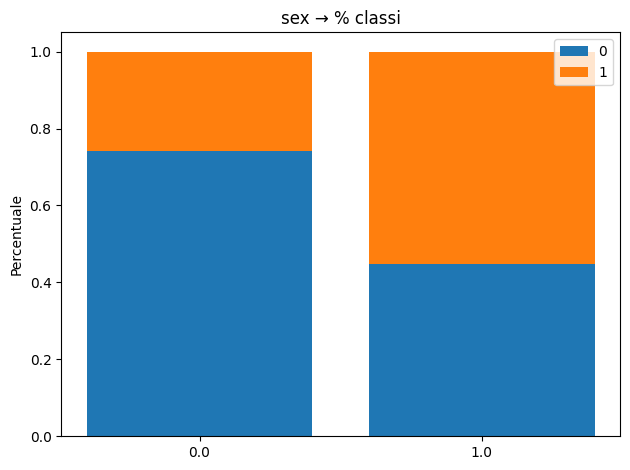

target,0,1
cp,,
1.0,0.696,0.304
2.0,0.820,0.180
3.0,0.791,0.209
4.0,0.271,0.729


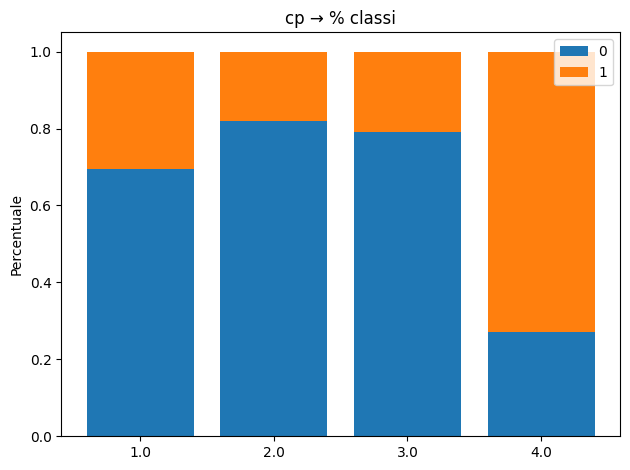

target,0,1
fbs,,
0.0,0.547,0.453
1.0,0.511,0.489


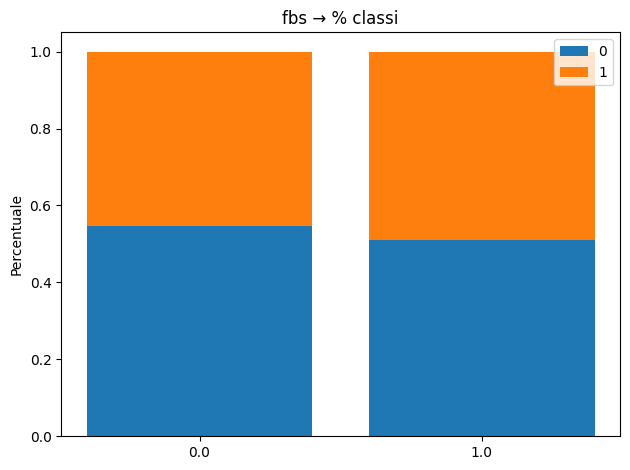

target,0,1
restecg,,
0.0,0.629,0.371
1.0,0.250,0.750
2.0,0.459,0.541


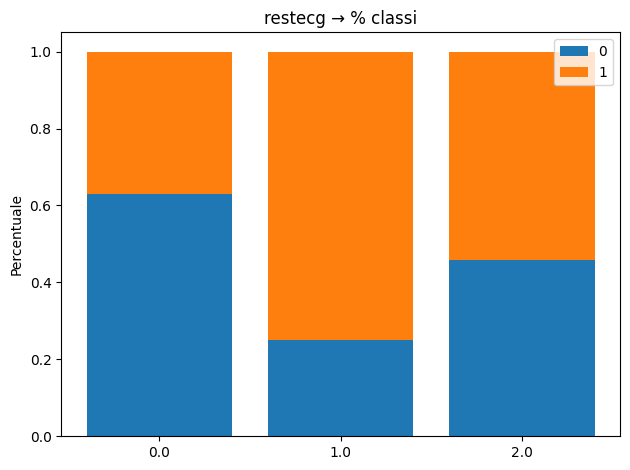

target,0,1
exang,,
0.0,0.691,0.309
1.0,0.232,0.768


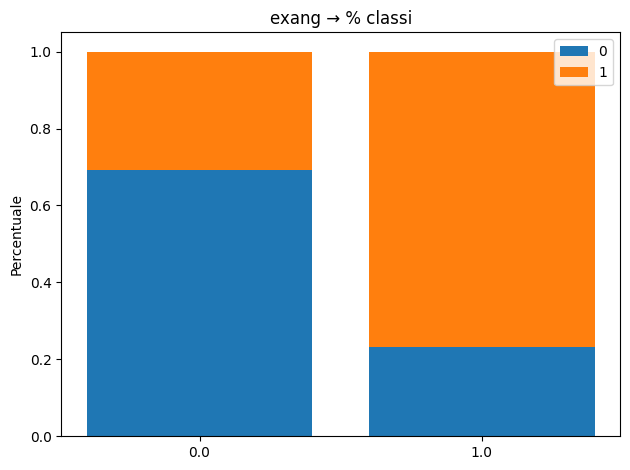

target,0,1
slope,,
1.0,0.746,0.254
2.0,0.350,0.650
3.0,0.429,0.571


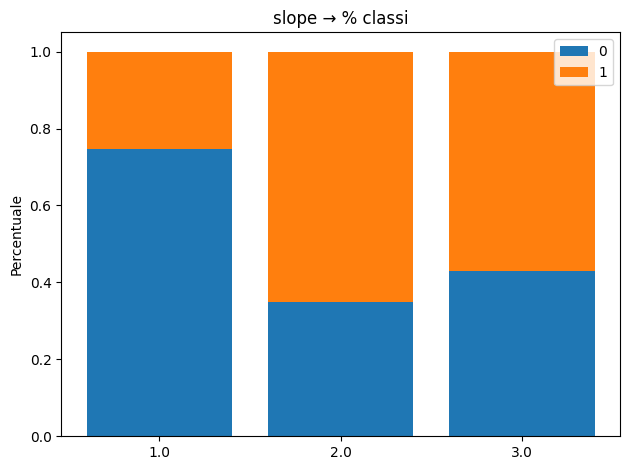

target,0,1
ca,,
0.0,0.739,0.261
1.0,0.323,0.677
2.0,0.184,0.816
3.0,0.150,0.850


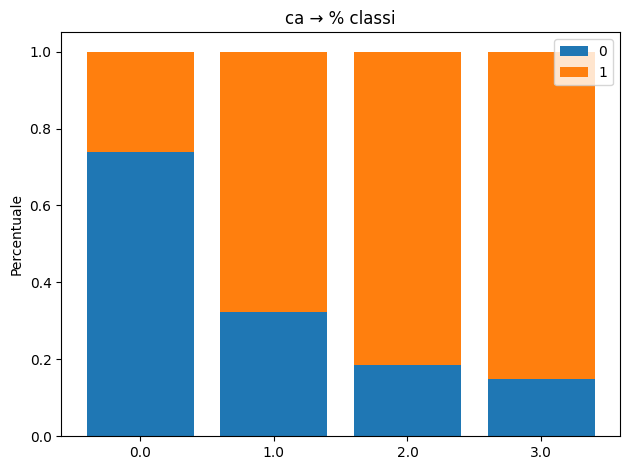

target,0,1
thal,,
3.0,0.777,0.223
6.0,0.333,0.667
7.0,0.239,0.761


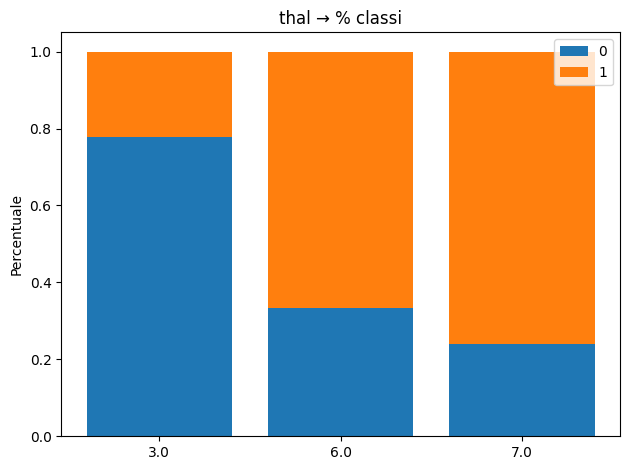

In [237]:
for col in CATEGORICAL:
    ct = pd.crosstab(df[col], df[TARGET_BIN], normalize="index").round(3)
    display(ct)

    plt.figure()
    idx = np.arange(len(ct.index))
    vals0 = ct.get(0, pd.Series([0]*len(ct), index=ct.index))
    vals1 = ct.get(1, pd.Series([0]*len(ct), index=ct.index))
    plt.bar(idx, vals0.values, label="0")
    plt.bar(idx, vals1.values, bottom=vals0.values, label="1")
    plt.xticks(idx, ct.index.astype(str), rotation=0)
    plt.title(f"{col} → % classi"); plt.ylabel("Percentuale")
    plt.legend()
    plt.tight_layout(); plt.show()



,age,trestbps,chol,thalach,oldpeak,target
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.223120
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.150825
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.085164
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.417167
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.424510
target,0.223120,0.150825,0.085164,-0.417167,0.424510,1.000000


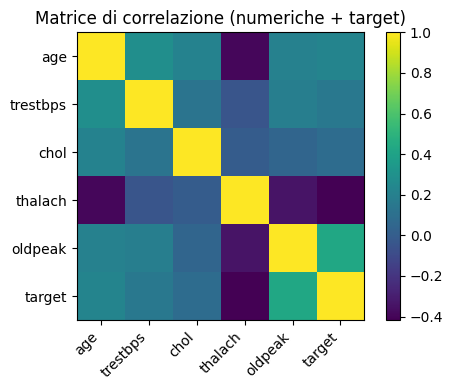

In [238]:
corr = df[NUMERIC + [TARGET_BIN]].corr()
display(corr)

plt.figure(figsize=(6,4))
im = plt.imshow(corr, interpolation="nearest")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
plt.yticks(range(corr.shape[0]), corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Matrice di correlazione (numeriche + target)")
plt.tight_layout(); plt.show()


<a id="conclusioni"></a>
## Conclusioni

Il dataset **Cleveland** contiene **303 righe × 15 colonne**. La qualità dei dati è buona: i valori mancanti sono pochi e localizzati su **`ca` (4 casi, 1.3%)** e **`thal` (2 casi, 0.7%)**, quindi un’imputazione semplice è adeguata. Il **target** è moderatamente sbilanciato con **164 negativi (0)** e **139 positivi (1)**, prevalenza ≈ **0.459**: ciò giustifica l’uso della **F1** come metrica principale (con **PR-AUC** come controllo).

Dalle **numeriche** emergono pattern coerenti con il dominio clinico:
- **`oldpeak`** è nettamente più alto nei positivi (mediana ≈ **1.4** vs **0.2** nei negativi) e mostra la **correlazione più alta con il target** fra le numeriche (**r ≈ +0.425**): indica maggiore depressione ST nei soggetti con malattia.
- **`thalach`** (frequenza cardiaca massima) è più bassa nei positivi (mediana più bassa; **r ≈ −0.417**), altro segnale atteso.
- **`age`** ha una correlazione positiva più modesta (**r ≈ +0.223**), mentre **`trestbps`** e **`chol`** mostrano legami deboli con il target (|r| ≲ 0.19).

Per le **categoriche** si vedono differenze marcate di percentuale di positivi tra categorie:
- **`cp`** (dolore toracico): la categoria **4** concentra circa **73%** di positivi, mentre **2** e **3** sono più “protettive” (≈ 18–21%).
- **`exang`** (angina da sforzo): quando **=1** la quota di positivi sale a **~77%**.
- **`slope`**: la categoria **2** ha ≈ **65%** di positivi (vs ~25% per la 1).
- **`ca`** (vasi colorati): cresce la quota di positivi al crescere di `ca`: **0 → ~26%**, **3 → ~85%**.
- **`thal`**: **7 (reversible)** ha ≈ **76%** di positivi; **6 (fixed)** ≈ **67%**; **3 (normal)** ≈ **22%**.

Nel complesso, i dati offrono segnali forti e interpretabili: **`oldpeak`, `thalach`, `cp`, `exang`, `slope`, `ca`, `thal`** risultano particolarmente informativi. Non si rilevano problemi sistematici di qualità che richiedano trattamenti complessi; gli **outlier** sembrano gestibili con modelli robusti e uno **scaling** standard.

**Scelte di preprocessing confermate:**
- Imputazione: **mediana** per numeriche; **più frequente** per categoriche.
- **StandardScaler** sulle numeriche (utile per KNN; non ha implicazini per RF/Tree).
- **One-Hot Encoding** con `handle_unknown="ignore"` sulle categoriche.
- Questo avviene tutto **dentro la Pipeline** per eliminare i leakage.

**Feature Engineering** (da validare tramite il cross-validation):Abbiamo introdotto cinque feature numeriche derivate e una categorica opzionale:

- `hr_reserve = thalach / (220 - age)`: normalizza la frequenza max rispetto all’età.
- `chol_age = chol / age`: aggiusta il colesterolo per l’età.
- `oldpeak_exang = oldpeak * 1{exang==1}`: interazione ischemia × sforzo.
- `oldpeak_slope = oldpeak * slope_code`: interazione ischemia × morfologia ST.
- `bp_age = trestbps / age`: carico pressorio relativo all’età.
- `age_bin` (opz.): discretizzazione di `age` in 5 fasce (poi One-Hot).

Manteniamo nel modello solo le feature che mostrano un incremento **stabile** di F1 in CV (≥ +0.01); in caso contrario vengono rimosse.


<a id="evitiamo-il-leakage"></a>
> ⚠️ **Evitiamo il leakage**
>
> - Qualunque trasformazione (imputazione, scaling, One-Hot, eventuale FE) deve essere **dentro la Pipeline** e fatta **solo** sul train, anche in cross-validation.
> - Le scelte di soglia (es. “best F1”) si prendono su **val/CV**, non guardando il test.
> - L’EDA serve a farsi un’idea, non a “tarare” i dati manualmente prima dello split.
